In [3]:
import fasttext
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv("train.csv")

In [5]:
df["rating"] = df["rating"].astype(int)

<Axes: xlabel='rating'>

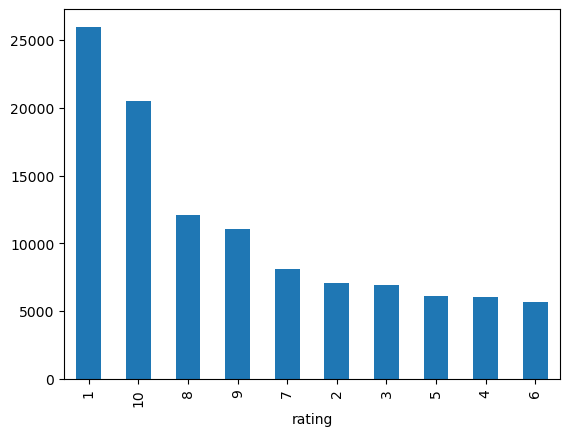

In [6]:
df["rating"].value_counts().plot(kind="bar")

In [7]:
def convert_binary(rating):
    return int(rating >= 6)


df["rating"] = df["rating"].map(convert_binary)

df["rating"] = df["rating"].astype(str)

<Axes: xlabel='rating'>

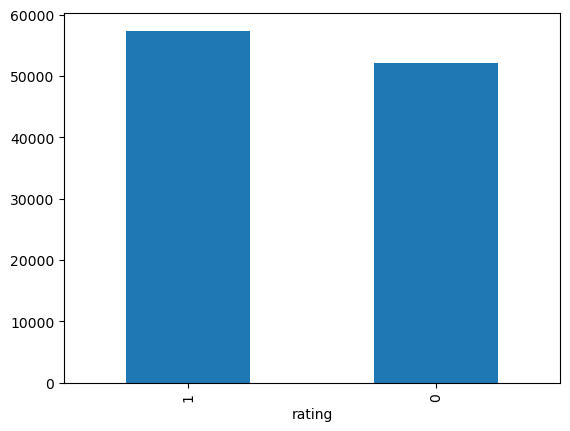

In [8]:
df["rating"].value_counts().plot(kind="bar")

In [9]:
df.head()

,Unnamed: 0,movie_id,rating,review
0,0,tt0111161,1,"Can Hollywood, usually creating things for ent..."
1,2,tt0111161,1,"In its Oscar year, Shawshank Redemption (writt..."
2,3,tt0111161,1,I believe that this film is the best story eve...
3,5,tt0111161,1,One of the finest films made in recent years. ...
4,6,tt0111161,1,This movie is not your ordinary Hollywood flic...


In [10]:
df["rating"].value_counts()

rating
1    57364
0    52155
Name: count, dtype: int64

In [11]:
df["rating"] = "__label__" + df["rating"]

In [12]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_file = "train.txt"
test_file = "test.txt"

train_df[["rating", "review"]].to_csv(train_file, sep="\t", header=None, index=None)
test_df[["rating", "review"]].to_csv(test_file, sep="\t", header=None, index=None)

In [13]:
model = fasttext.train_supervised(input=train_file, epoch=50, lr=0.5, wordNgrams=2)

Read 22M words
Number of words:  695915
Number of labels: 2
Progress: 100.0% words/sec/thread:  551199 lr:  0.000000 avg.loss:  0.033389 ETA:   0h 0m 0s


In [14]:
results = model.test(test_file)

In [59]:
print(f"Test accuracy: {results[1] * 100:.4}%")

Test accuracy: 88.76%


In [16]:
thematic_words = {
    "Marine Life": ["sea", "ocean", "water", "fish", "surfing", "beach"],
    "Space Exploration": ["astronaut", "rocket", "galaxy", "planet", "satellite", "cosmos"],
    "Mountain Adventure": ["mountain", "hiking", "trail", "summit", "backpack", "campfire"],
    "Urban Life": ["city", "skyscraper", "traffic", "metro", "nightlife", "sidewalk"],
    "Art and Painting": ["canvas", "brush", "palette", "acrylic", "mural", "easel"],
    "Cooking and Cuisine": ["chef", "recipe", "oven", "ingredients", "cuisine", "sauté"],
    "Music and Performance": ["melody", "rhythm", "concert", "orchestra", "guitar", "piano"],
    "Gardening and Horticulture": ["plant", "flower", "soil", "greenhouse", "pruning", "fertilizer"],
    "Computer Technology": ["software", "hardware", "programming", "database", "algorithm", "cybersecurity"],
    "Sports and Fitness": ["gym", "soccer", "marathon", "yoga", "training", "basketball"],
    "Test": ["king", "kingdom", "kingkong", "kin"]
}

In [17]:
import matplotlib.pyplot as plt

word_vectors = []
word_labels = []
colors = plt.cm.get_cmap("rainbow", len(thematic_words))

for i, (theme, words) in enumerate(thematic_words.items()):
    for word in words:
        word_vectors.append(model.get_word_vector(word))
        word_labels.append(i)

/tmp/ipykernel_2272/3899444841.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("rainbow", len(thematic_words))


In [18]:
import numpy as np

word_vectors = np.array(word_vectors)
word_labels = np.array(word_labels)

In [19]:
word_vectors.shape

(64, 100)

In [20]:
def draw_projection(method_name, word_vectors_2d):
    plt.figure(figsize=(12, 8))

    for i, theme in enumerate(thematic_words.keys()):
        indices = np.where(word_labels == i)
        plt.scatter(
            word_vectors_2d[indices, 0],
            word_vectors_2d[indices, 1],
            label=theme,
            color=colors(i),
        )

    plt.legend()
    plt.title(method_name)
    plt.show()

In [21]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import numpy as np


pca = PCA(n_components=2)
word_vectors_2d_pca = pca.fit_transform(word_vectors)

tsne = TSNE(n_components=2, random_state=0)
word_vectors_2d_tsne = tsne.fit_transform(np.array(word_vectors))

reducer = umap.UMAP()
word_vectors_2d_umap = reducer.fit_transform(word_vectors)

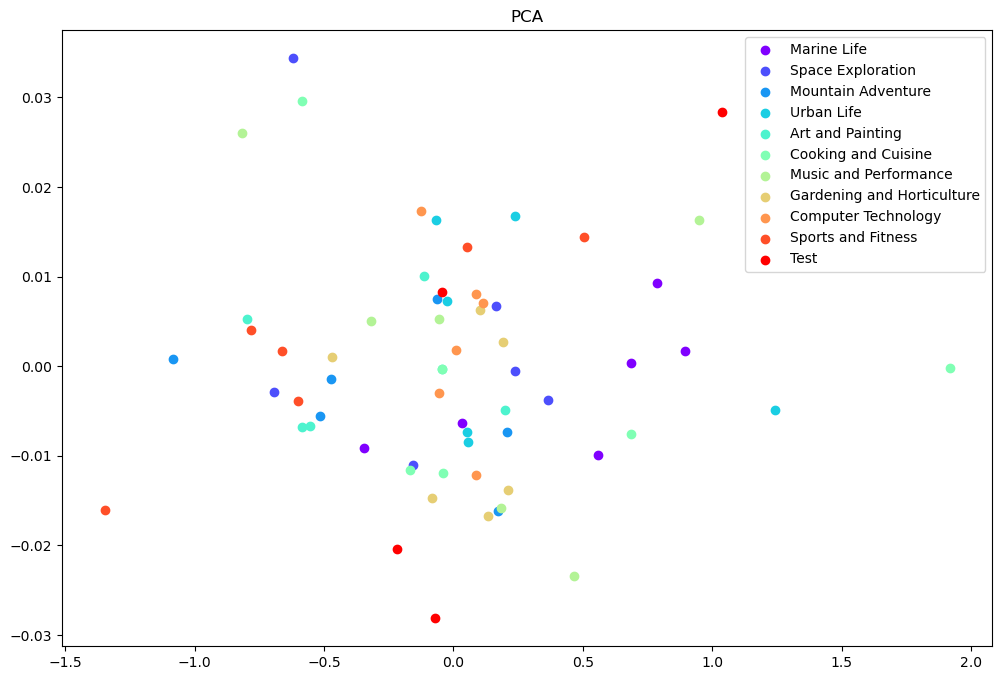

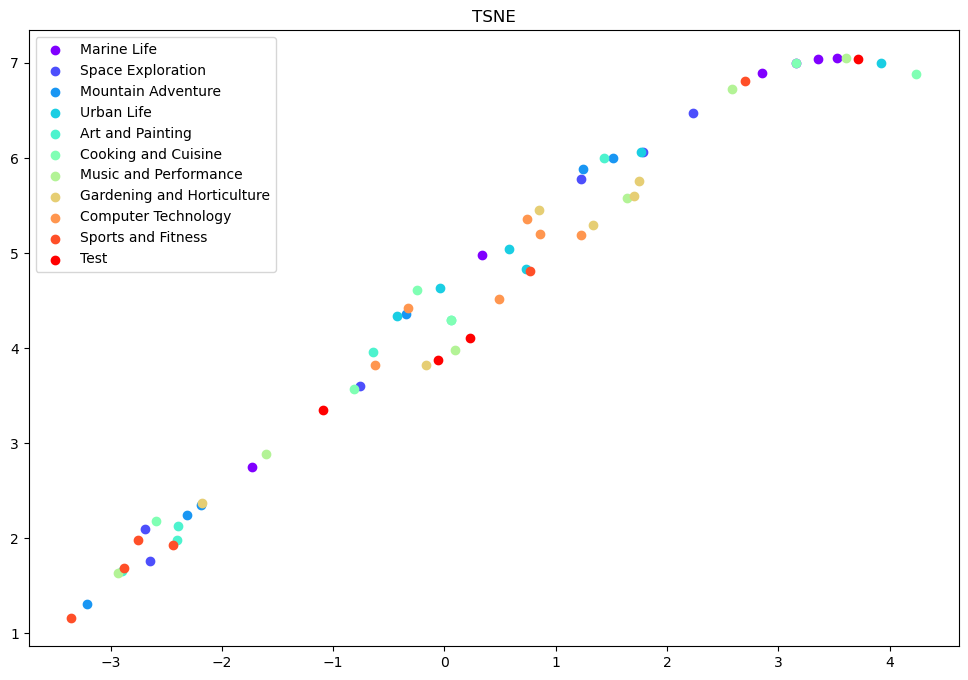

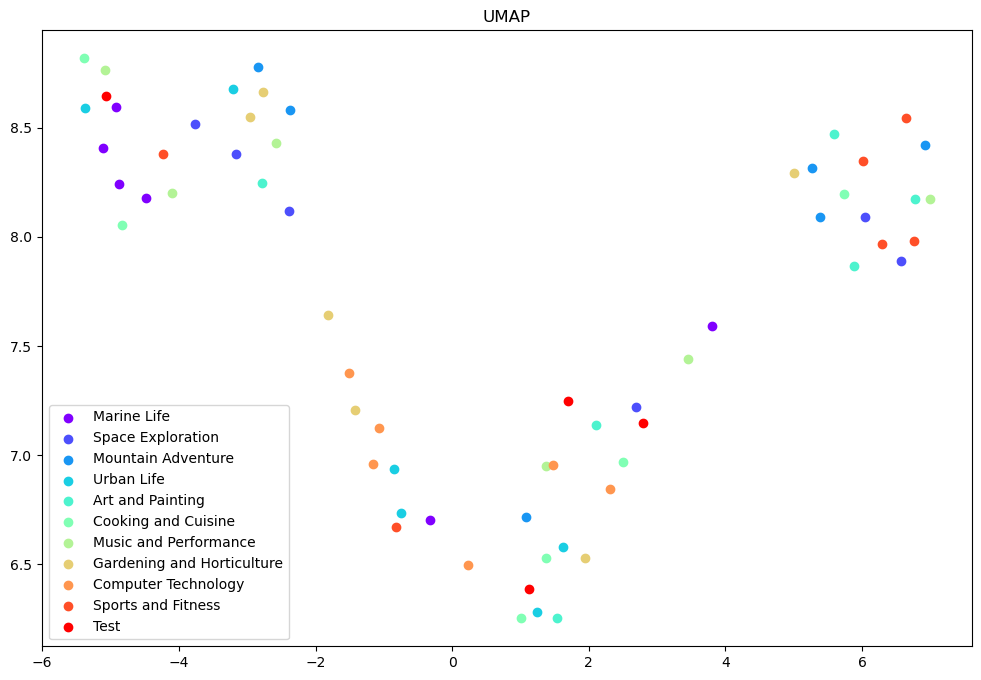

In [22]:
draw_projection("PCA", word_vectors_2d_pca)
draw_projection("TSNE", word_vectors_2d_tsne)
draw_projection("UMAP", word_vectors_2d_umap)

### BERT Embeddings

In [26]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
import torch


model_name = "lvwerra/distilbert-imdb"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, 
                                                            output_hidden_states=True, 
                                                            output_attentions=True)
model.classifier = torch.nn.Identity()


def get_bert_vector(word):
    inputs = tokenizer(word, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs[0][0].numpy().tolist()

In [27]:
import matplotlib.pyplot as plt

word_vectors = []
word_labels = []
colors = plt.cm.get_cmap("rainbow", len(thematic_words))

for i, (theme, words) in enumerate(thematic_words.items()):
    for word in words:
        word_vectors.append(get_bert_vector(word))
        word_labels.append(i)

/tmp/ipykernel_2272/1809580156.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("rainbow", len(thematic_words))


In [28]:
word_vectors = np.array(word_vectors)
word_labels = np.array(word_labels)

In [29]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import numpy as np


pca = PCA(n_components=2)
word_vectors_2d_pca = pca.fit_transform(word_vectors)

tsne = TSNE(n_components=2, random_state=0)
word_vectors_2d_tsne = tsne.fit_transform(np.array(word_vectors))

reducer = umap.UMAP()
word_vectors_2d_umap = reducer.fit_transform(word_vectors)

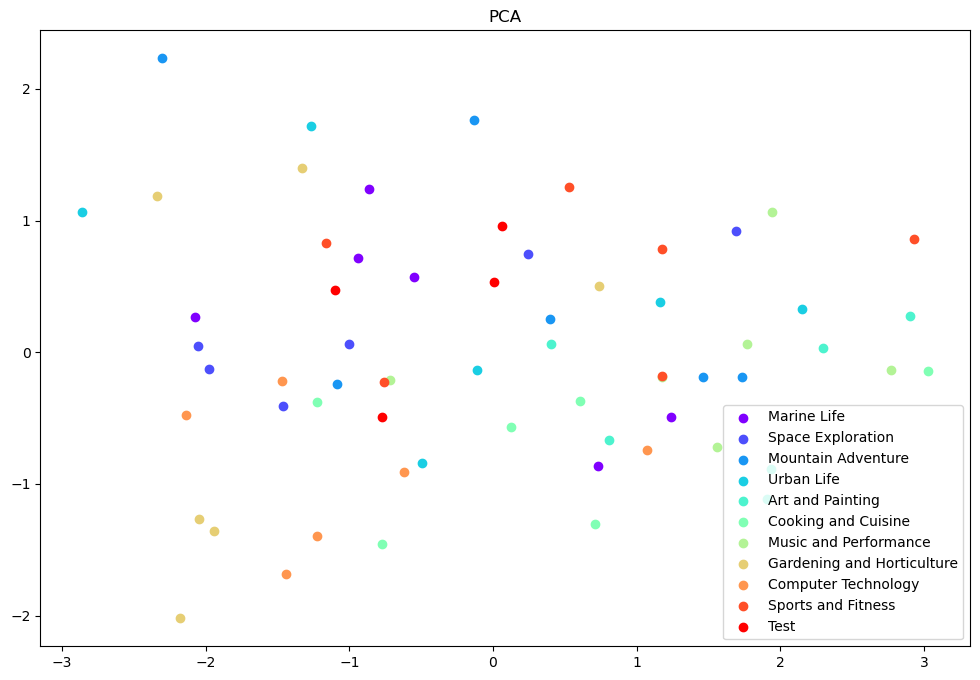

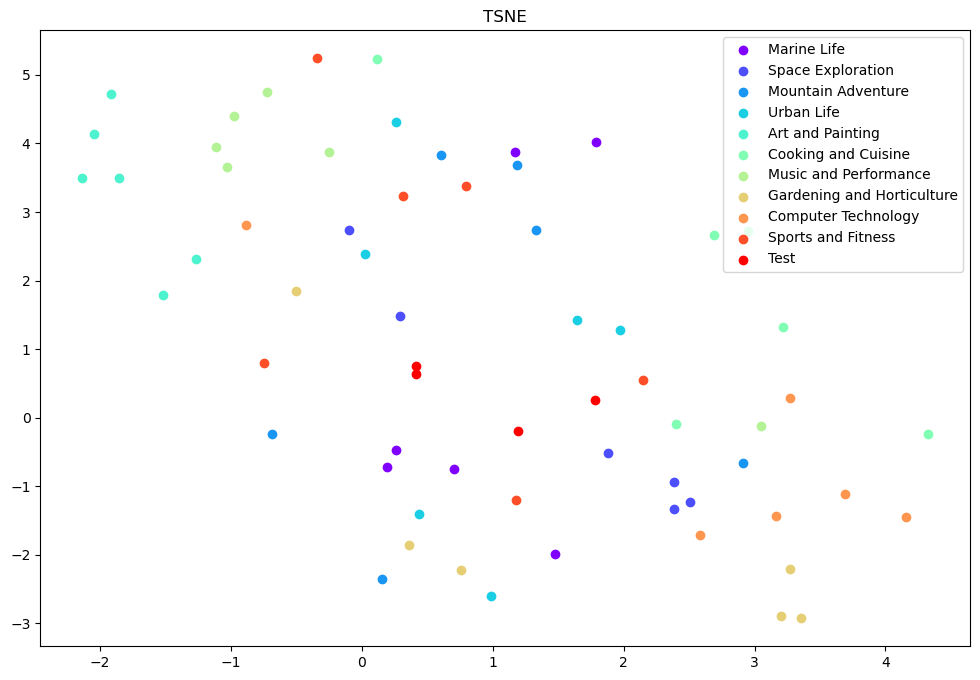

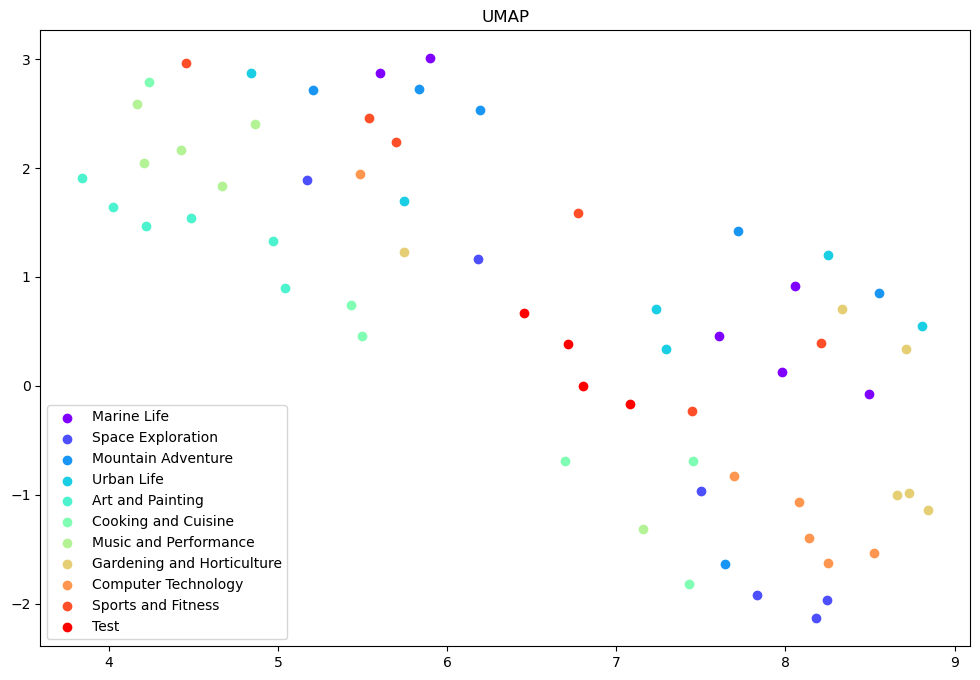

In [30]:
draw_projection("PCA", word_vectors_2d_pca)
draw_projection("TSNE", word_vectors_2d_tsne)
draw_projection("UMAP", word_vectors_2d_umap)

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

tfidf_vectors = tfidf_vectorizer.fit(train_df['review'])

In [52]:
import matplotlib.pyplot as plt

word_vectors = []
word_labels = []

colors = plt.cm.get_cmap("rainbow", len(thematic_words))

for i, (theme, words) in enumerate(thematic_words.items()):
    for word in words:
        word_vectors.append(tfidf_vectorizer.transform([word]).toarray()[0])
        word_labels.append(i)

word_vectors = np.array(word_vectors)
word_labels = np.array(word_labels)

/tmp/ipykernel_2272/3260149783.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("rainbow", len(thematic_words))


In [53]:
pca = PCA(n_components=2)
word_vectors_2d_pca = pca.fit_transform(word_vectors)

tsne = TSNE(n_components=2, random_state=0)
word_vectors_2d_tsne = tsne.fit_transform(np.array(word_vectors))

reducer = umap.UMAP()
word_vectors_2d_umap = reducer.fit_transform(word_vectors)

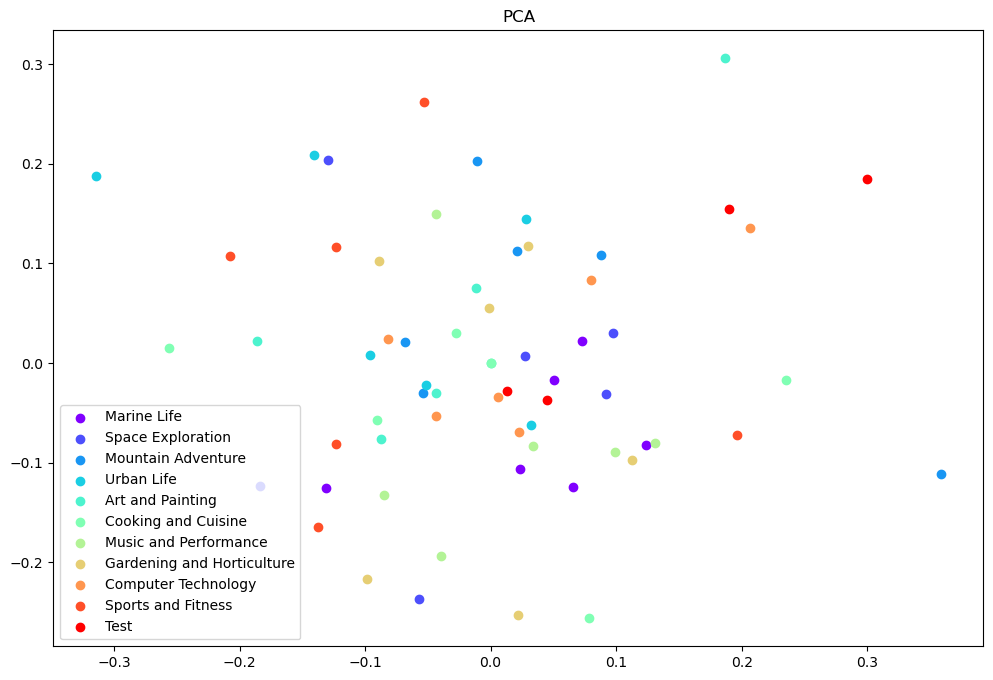

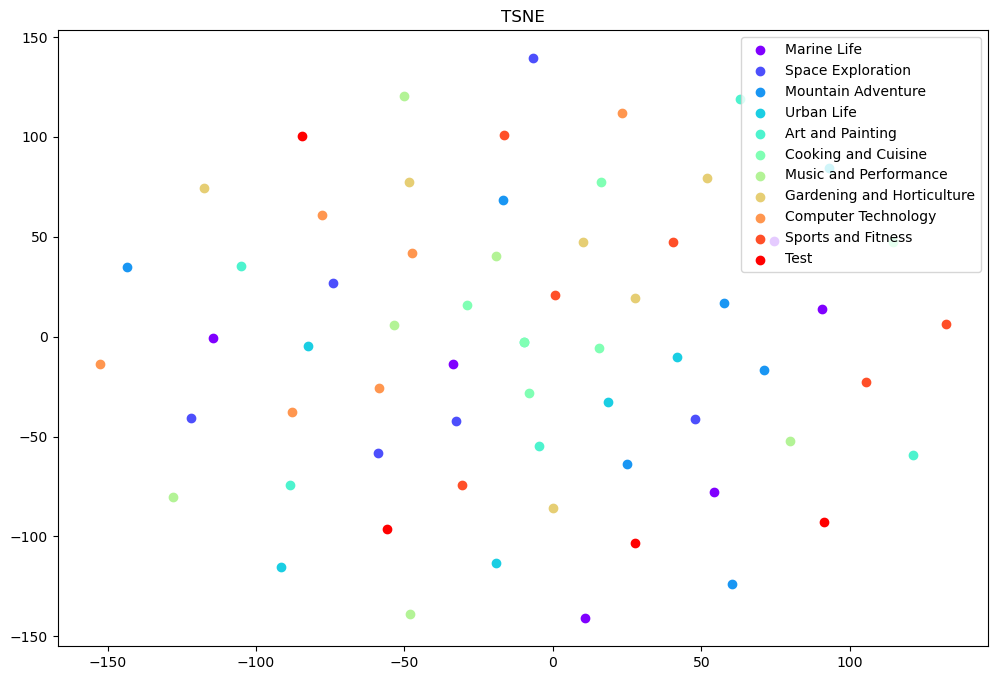

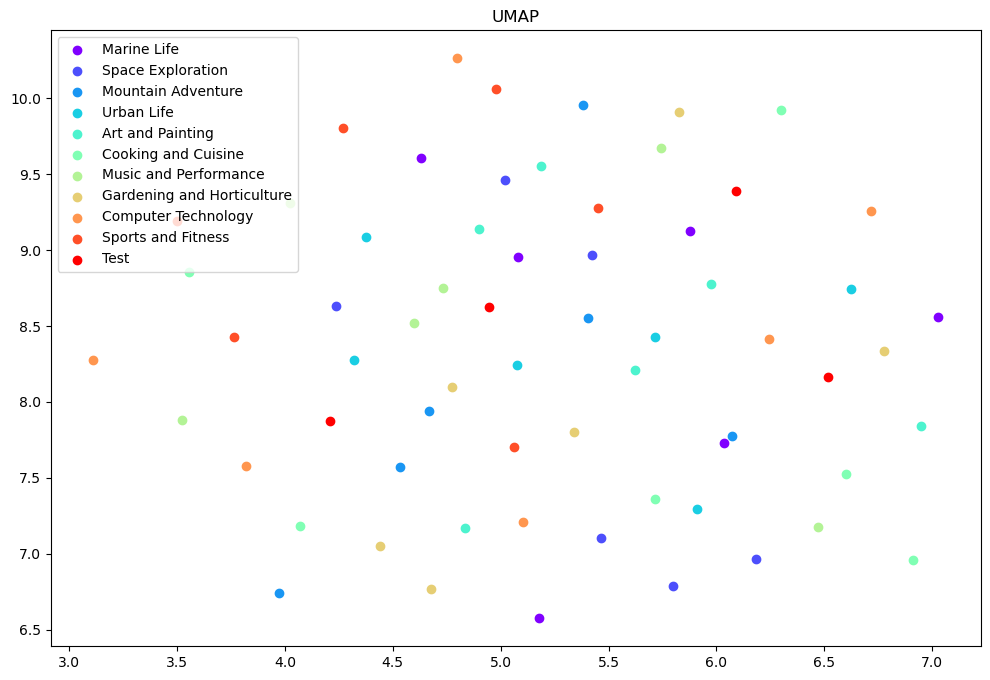

In [54]:
draw_projection("PCA", word_vectors_2d_pca)
draw_projection("TSNE", word_vectors_2d_tsne)
draw_projection("UMAP", word_vectors_2d_umap)